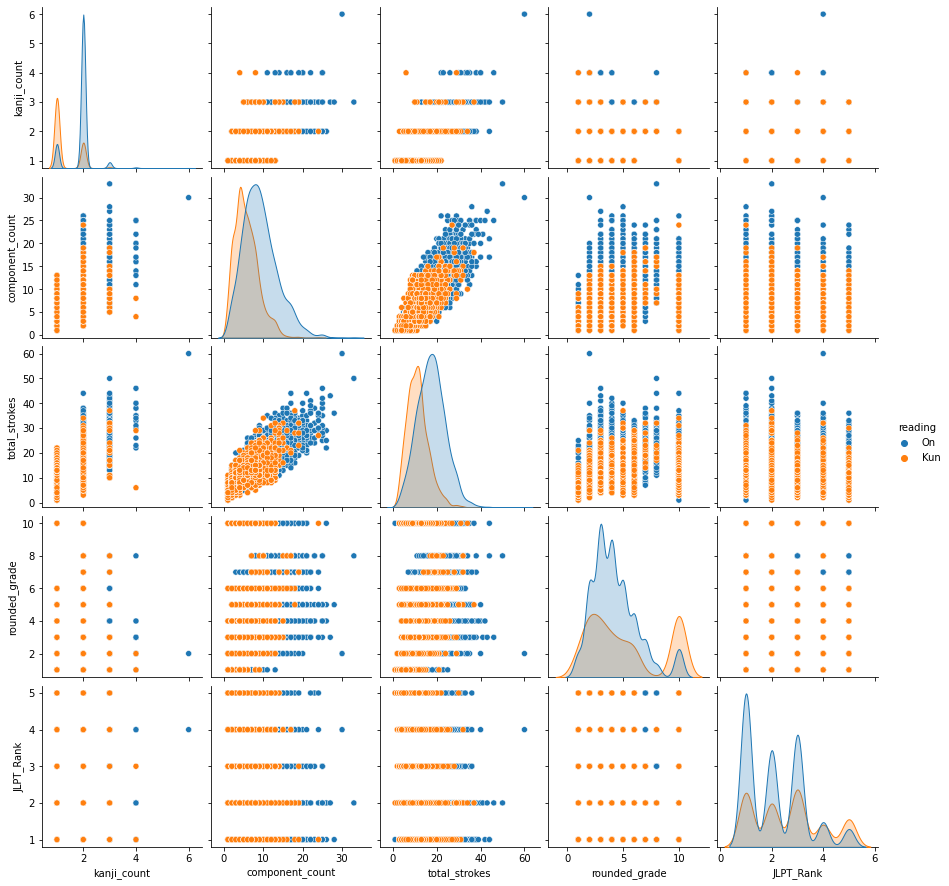

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"https://raw.githubusercontent.com/MikeGillotti/capstone-project/refs/heads/main/resources/japanese%20data.csv")

df.drop('average_grade', axis=1, inplace=True)
df = df[df['reading'] != "Irregular"]
df = df[df['reading'] != "Mixed"]

df=df.sort_values(by=['reading'], ascending=False)
plot_df=df[['kanji_count', 'component_count', 'total_strokes', 'rounded_grade', 'JLPT_Rank', 'reading']]
sns.pairplot(data=plot_df, hue="reading")
plt.show()

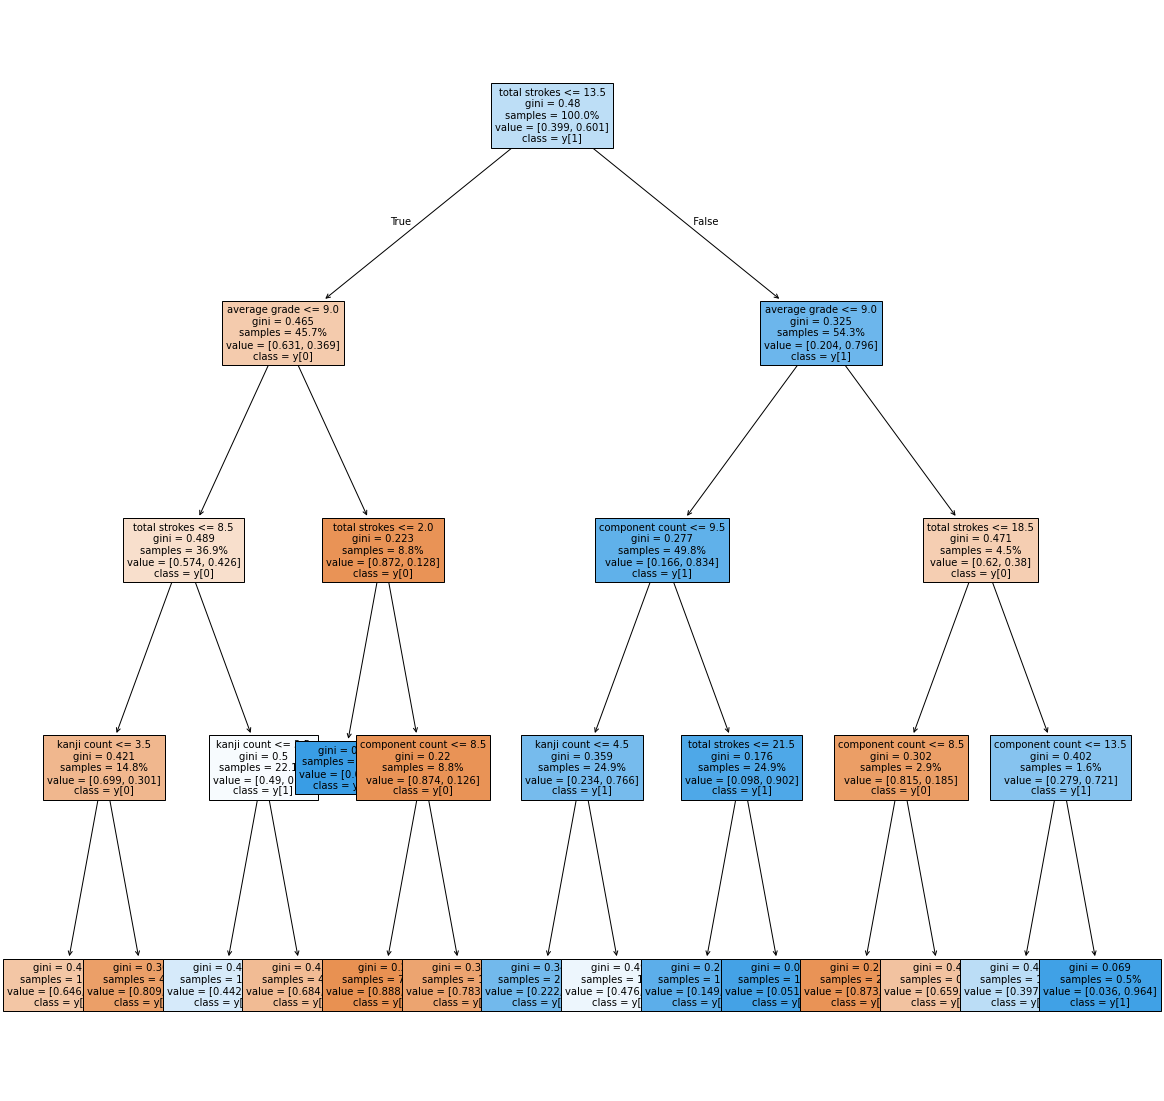

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree

X = df[['component_count', 'JLPT_Rank', 'rounded_grade', 'total_strokes']]
y = df['reading']
app_id=df[['id', 'kanji_count']]
X_train, X_test, y_train, y_test, app_id_train, app_id_test = train_test_split(X, y, app_id, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)
plt.figure(figsize=(20,20))
tree.plot_tree(clf, proportion=True, filled=True, fontsize=10, class_names=True, feature_names=["component count", "kanji count", "average grade", "total strokes", "reading number"])
plt.show()

In [3]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7805810397553516


In [4]:
from itertools import product
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

X = df[['component_count', 'JLPT_Rank', 'rounded_grade', 'total_strokes']]
y = df['reading']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=0.1, kernel="rbf", probability=True)
eclf = VotingClassifier(
    estimators=[("dt", clf1), ("knn", clf2), ("svc", clf3)],
    voting="soft",
    weights=[2, 1, 2],
)

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
eclf.fit(X_train, y_train)



VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=4)),
                             ('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('svc', SVC(gamma=0.1, probability=True))],
                 voting='soft', weights=[2, 1, 2])

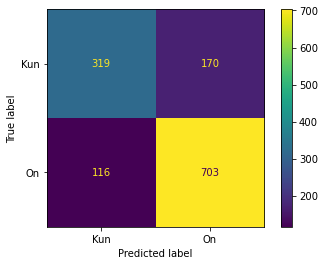

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

ConfusionMatrixDisplay.from_estimator(clf3, X_test, y_test)
plt.show()

In [6]:
import ipywidgets as widgets
import warnings
from IPython.display import display, clear_output
warnings.simplefilter(action='ignore', category=UserWarning)

dfr = pd.read_csv(r"https://raw.githubusercontent.com/MikeGillotti/capstone-project/refs/heads/main/resources/japanese%20data%20app%20resource.csv")

y_pred = eclf.predict(X_test)
results_df= pd.DataFrame({
    'actual': y_test,           
    'predicted': y_pred 
})


jlpt_rank_widget = widgets.IntSlider(description='JLPT Rank', value='0',min=1, max=5)

button_false_predict = widgets.Button( description='False Predictions' )
button_true_predict = widgets.Button( description='True Predictions' )

def on_click_predict(b):

    q=X_test.join(results_df).join(app_id_test).query(f"JLPT_Rank=={jlpt_rank_widget.value}")
    q_predict=q.query(f"{b}")
    app_df=pd.merge(q_predict, dfr, left_on='id', right_on='japanese data id', how='left')
    clear_output(wait=True)
    display(vb)    
    mode_df=pd.DataFrame({
    'feature':   ["predicted",
              "predicted",
              "kanji",
                  "kanji count",
                  "component count",
                  "total strokes",
                  "average grade"],       
    'mode': [app_df['predicted'].value_counts().index[0],
            app_df['predicted'].value_counts().index[1],
               app_df['kanji'].value_counts().index[0],
             app_df['kanji_count'].value_counts().index[0],
              app_df['component_count'].value_counts().index[0],
              app_df['total_strokes'].value_counts().index[0],
              app_df['rounded_grade'].value_counts().index[0]
              
        ],
    'frequency':[app_df['predicted'].value_counts().iloc[0],
                app_df['predicted'].value_counts().iloc[1],
                app_df['kanji'].value_counts().iloc[0],
                 app_df['kanji_count'].value_counts().iloc[0],
             app_df['component_count'].value_counts().iloc[0],
                app_df['total_strokes'].value_counts().iloc[0],
            app_df['rounded_grade'].value_counts().iloc[0]]

})
    filtered_accuracy = accuracy_score(q['actual'], q['predicted'])

    print(f"JLPT {jlpt_rank_widget.value} accuracy: {filtered_accuracy}")
    display(mode_df)

    display(app_df[['kanji', 'kana','meaning', 'actual']])

  
    


    
button_false_predict.on_click(lambda b: on_click_predict("actual!=predicted"))
button_true_predict.on_click(lambda b: on_click_predict("actual==predicted"))

#Displays the text boxes and buttons inside a VBox 
vb=widgets.VBox([
                jlpt_rank_widget,
                button_false_predict,
                button_true_predict,
])
display(vb)

#app_joined
#dfr
#app_joined.join(dfr.set_index(dfr['japanese data id']), on='id')
